# Analyzing iMessage groupchats

This code is expected to be run in a jupyter/ipython notebook. 

This notebook covers: 
1. Extracting the data from the output of "imessage_export"
2. Cleaning the data and integrating it with your contacts list
3. Doing a bunch of random data science analysis on the data, and some instructions on how to expand.
4. Packaging these messages in a format understood by OpenAI's GPT models, in order to get some LLM group chat predictions/thoughts.

In [4]:
import os
import re
import pandas as pd
import openai
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# Extracting the data from a group chat
This function does the legword of combing through all the messages output in the text file created by imessage_export, and appropriately clustering them into single texts with relevant metadata, including: who sent it, when did they sent it, what was the content, who reacted to it, and what was their reaction (fun fact -- I guess iMessage refers to these as "tapbacks"). There's also a little bit of finnegaling for some of the quirks of imessage, such as the "response" format. 


In [33]:
import re

# Function to parse the data from a txt file
def parse_messages_from_file(file_path):
    # Read the file contents
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Variables to store extracted data
    timestamps = []
    senders = []
    contents = []

    in_tapbacks = False
    
    current_timestamp = None
    current_sender = None
    current_content = []

    # Regular expression patterns
    timestamp_long_pattern = re.compile(r"^\w{3} \d{1,2}, \d{4} {1,2}\d{1,2}:\d{2}:\d{2} [APM]{2}.*$")
    timestamp_pattern = re.compile(r"^\w{3} \d{1,2}, \d{4} {1,2}\d{1,2}:\d{2}:\d{2} [APM]{2}")
    tapback_pattern = re.compile(r"^Tapbacks:")
    response_pattern = re.compile(r"This message responded to an earlier message\.")
    
    for line in lines:
        line = line.strip()
        
        # Check if the line is a timestamp
        if timestamp_long_pattern.match(line):
            in_tapbacks = False
            # Save the current message if it's complete
            if current_timestamp and current_sender and current_content:
                timestamps.append(current_timestamp)
                senders.append(current_sender)
                contents.append(" ".join(current_content).strip())

            # Start a new message
            current_timestamp = timestamp_pattern.match(line).group()
            current_sender = None
            current_content = []
        
        # Check if the line contains a tapback or response note
        elif in_tapbacks or response_pattern.match(line):
            continue

        elif tapback_pattern.match(line):
            in_tapbacks = True
            continue
        
        # Check if the line looks like a sender (email or phone number)
        elif re.match(r"^[\w.+-]+@[\w-]+\.[\w.-]+$|^\+\d+$|^Me$", line):
            current_sender = line.strip()
        
        # Otherwise, it's part of the message content
        else:
            current_content.append(line.strip())
    
    # Add the last message if it's complete
    if current_timestamp and current_sender and current_content:
        timestamps.append(current_timestamp)
        senders.append(current_sender)
        contents.append(" ".join(current_content).strip())

    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Sender': senders,
        'Content': contents
    })

    return df

Now we just apply that logic on each of the relevant group chat files (because of some weirdness with imessage_exporter, there can sometimes be multiple files for one grouchat), and then at the end we should have a single dataframe with distinct rows for each text message.

In [34]:
# Define the path to the folder containing the text files
folder_path = "imessage_export"
groupNameToFind = "Jungs"

# Create an empty list to store the contents of each text file
file_contents = []
file_names = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if groupNameToFind in filename:
        file_names.append(folder_path + "/"  +filename)

# Load and display the parsed DataFrames from each relevant chat 
df = pd.concat([parse_messages_from_file(file_name) for file_name in file_names])


print(df)

['imessage_export/Jungs - 1639.txt', 'imessage_export/Jungs - 17.txt']

## Optional: Add Contacts as names instead of phone numbers

If you want to have contact names instead of phone numbers, you can export your contacts as a CSV from your address book, and then use this code to add another column to our main dataframe with the contact name instead of their phone number. This code expects a file called "contacts.csv" which has columns for: first name, last name, and phone number (matching the default export pattern from a Mac). 

In [1]:
contactsdf = pd.read_csv('contacts.csv')

# Function to clean phone numbers: remove spaces, parentheses, and dashes
def clean_phone_number(phone):
    if pd.isna(phone):
        return None  # Handle missing values
    phone = str(phone)  # Convert to string if not already
    cleaned_phone = re.sub(r'[()\s-]', '', phone)  # Remove '+', parentheses, spaces, and dashes
    return cleaned_phone

# Apply the cleaning function to the Phone column
contactsdf['Phone'] = contactsdf['Phone'].apply(clean_phone_number)

# Create a dictionary with Phone as key and Full Name as value
phone_to_name = dict(zip(contactsdf['Phone'], contactsdf['First name'] + '_' + contactsdf['Last name']))
phone_to_name["Me"] = "My name" # helpful line if you'd like to share this data. You can also add any other weird contact things, like international phone numbers that weren't caught earlier.

df['Sender'] = df['Sender'].apply(lambda x: phone_to_name.get(x, x)) # optional line, if you have a contacts file
display(df)

NameError: name 'pd' is not defined

# Data Analysis

## 1. Most Messages Sent (by Sender)
Count the number of messages each sender has sent.

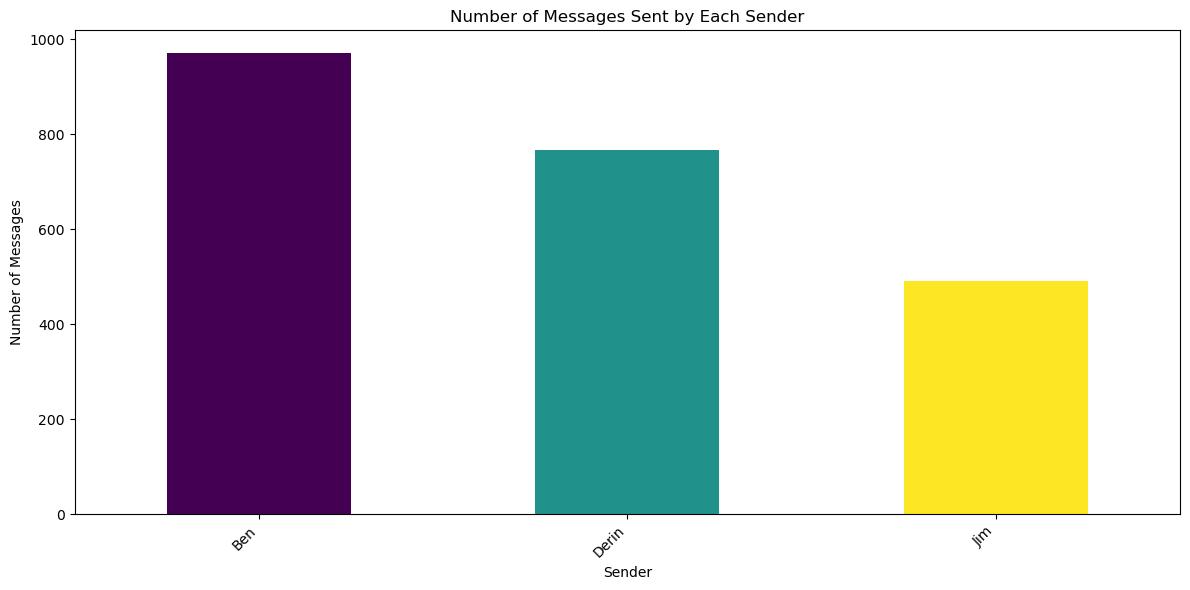

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of messages sent by each sender
most_messages = df['Sender'].value_counts()

# Generate a color for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(most_messages)))

# Plot the results with different colors for each bar
plt.figure(figsize=(12, 6))
most_messages.plot(kind='bar', color=colors)
plt.title('Number of Messages Sent by Each Sender')
plt.xlabel('Sender')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels properly
plt.show()


## 2. Time of Day Analysis
Check the distribution of messages sent at different times of the day.

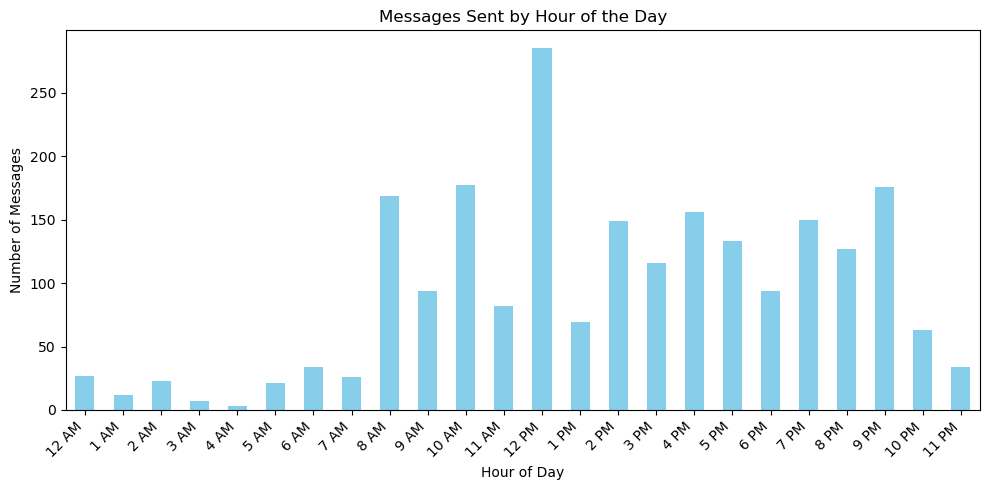

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the hour from the Timestamp
df['Hour'] = df['Timestamp'].dt.hour

# Group messages by hour of the day
messages_by_hour = df['Hour'].value_counts().sort_index()

# Convert hour to 12-hour format with AM/PM
hour_labels = [(str(hour % 12 or 12) + ' ' + ('AM' if hour < 12 else 'PM')) for hour in messages_by_hour.index]

# Plot the results
plt.figure(figsize=(10, 5))
messages_by_hour.plot(kind='bar', color='skyblue')
plt.title('Messages Sent by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')

# Set the x-axis labels to the 12-hour formatted times
plt.xticks(ticks=range(len(hour_labels)), labels=hour_labels, rotation=0)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 3. Messages Over Time
Visualize how the number of messages varies over time, such as daily or monthly trends.

In [60]:
# Ensure the 'Timestamp' column is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the year and month from the Timestamp
df['YearMonth'] = df['Timestamp'].dt.to_period('M')

# Group by Year-Month (month-wise count of messages)
messages_by_month = df['YearMonth'].value_counts().sort_index()

# Plot the results
# plt.figure(figsize=(12, 6))
# messages_by_month.plot(kind='line', marker='o', color='skyblue')
# plt.title('Messages Sent Over Time (Monthly)')
# plt.xlabel('Month')
# plt.ylabel('Number of Messages')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

print(messages_by_month)

YearMonth
2017-10     20
2017-12      2
2018-05      4
2018-08      4
2018-10     21
2018-12    253
2019-01     15
2019-02     38
2019-03     26
2019-04     41
2019-05     96
2019-09      5
2019-10      6
2019-11     28
2019-12      4
2020-01     40
2020-11     28
2021-07     97
2021-08    119
2021-09     33
2021-10     24
2021-11     26
2021-12    135
2022-01    179
2022-02     94
2022-03     52
2022-04     19
2022-05     38
2022-06     36
2022-07     64
2022-08     87
2022-09    250
2022-10     48
2022-11     13
2022-12     53
2023-01     33
2023-02     44
2023-03     47
2023-04     15
2024-08      7
2024-09     71
2024-10     12
Freq: M, Name: count, dtype: int64


## 4. Messages by Day of the Week
Check which days of the week have the most activity.

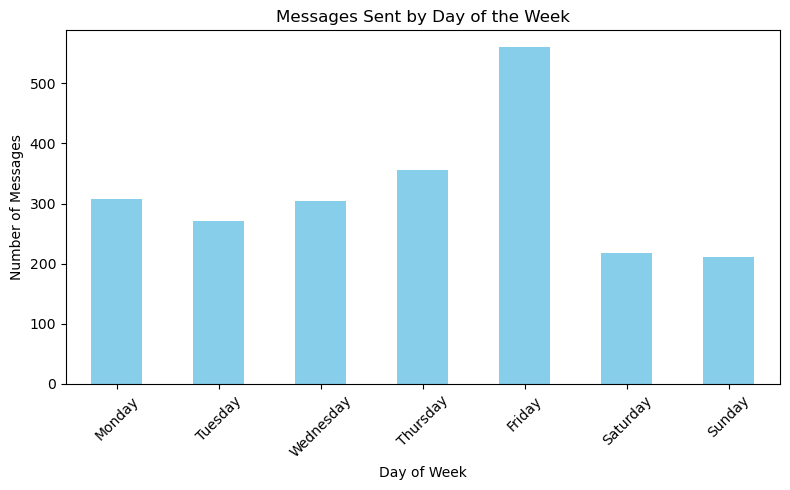

In [48]:
# Extract the day of the week from the Timestamp
df['DayOfWeek'] = df['Timestamp'].dt.day_name()

# Group by day of the week
messages_by_day = df['DayOfWeek'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the results
plt.figure(figsize=(8, 5))
messages_by_day.plot(kind='bar', color='skyblue')
plt.title('Messages Sent by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Word Frequency Analysis
Analyze the most commonly used words (excluding common stop words) in the chat content.

In [49]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine all messages into a single string
all_text = ' '.join(df['Content'].dropna()).lower()

# Tokenize the text (split into words)
words = all_text.split()

# Remove stop words and count the frequency of a remaining words
filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
word_freq = Counter(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jimhollingworth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


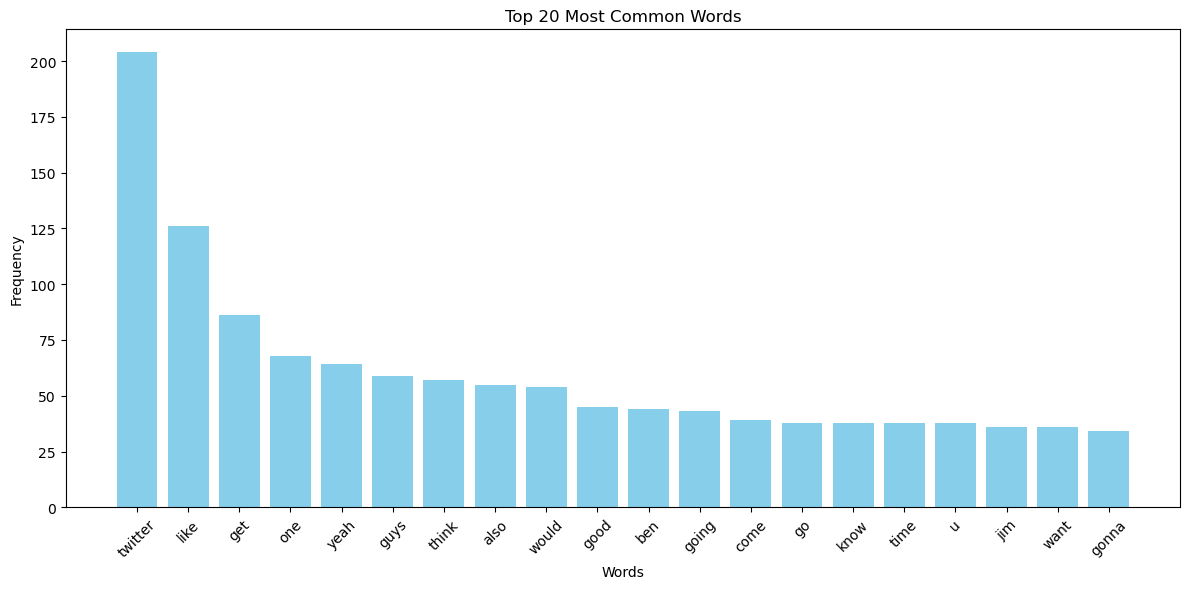

In [50]:
# Get the top 20 most common words and their frequencies
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Message Length Analysis
Analyze the average length of messages by sender.

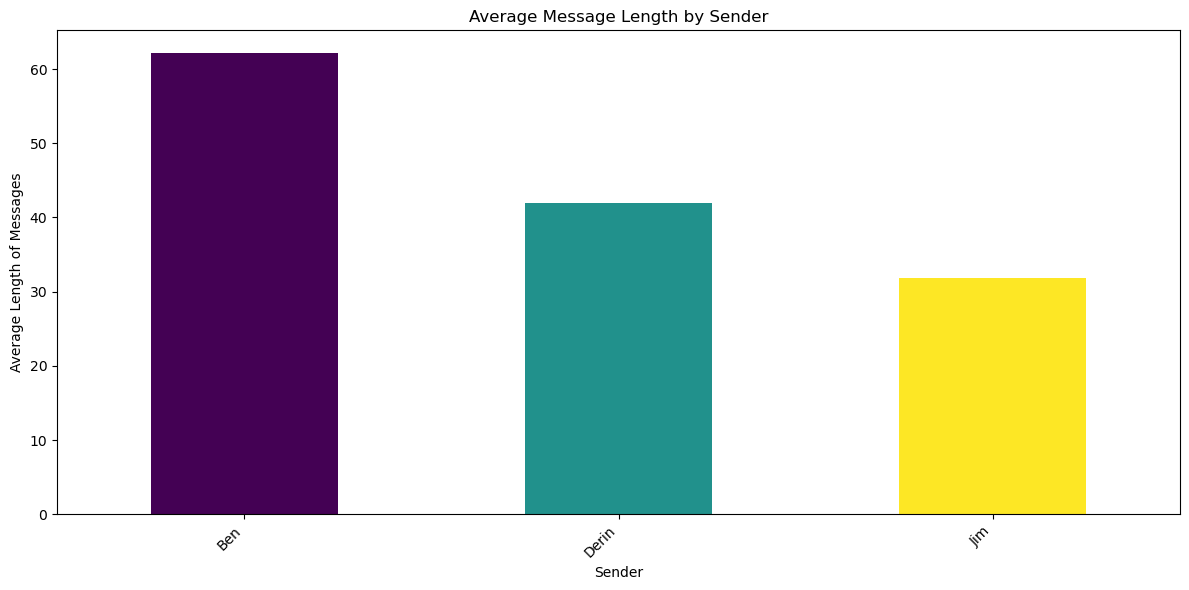

In [53]:
# Calculate the length of each message
df['MessageLength'] = df['Content'].apply(lambda x: len(str(x)))

# Group by sender and calculate the average message length
average_length_by_sender = df.groupby('Sender')['MessageLength'].mean().sort_values(ascending=False)

# Plot the average message length
plt.figure(figsize=(12, 6))
average_length_by_sender.plot(kind='bar', color=colors)
plt.title('Average Message Length by Sender')
plt.xlabel('Sender')
plt.ylabel('Average Length of Messages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Emoji Analysis
Identify the most frequently used emojis in the chat content.

In [54]:
import emoji

# Function to extract emojis from a message
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Apply the emoji extraction function to each message
df['Emojis'] = df['Content'].apply(lambda x: extract_emojis(str(x)))

# Flatten the list of all emojis in the dataset
all_emojis = [item for sublist in df['Emojis'] for item in sublist]

# Count the frequency of each emoji
emoji_freq = Counter(all_emojis)

# Display the most common emojis
print("Most common emojis in the chat:")
print(emoji_freq.most_common(10))

Most common emojis in the chat:
[('😭', 13), ('🙏', 10), ('😂', 7), ('🔥', 6), ('💫', 4), ('😵', 3), ('🤸', 2), ('👿', 2), ('🌀', 2), ('🕷', 2)]


## 8. Heatmap of Messages by Hour and Day of the Week
Create a heatmap to show the activity in the chat by hour and day.

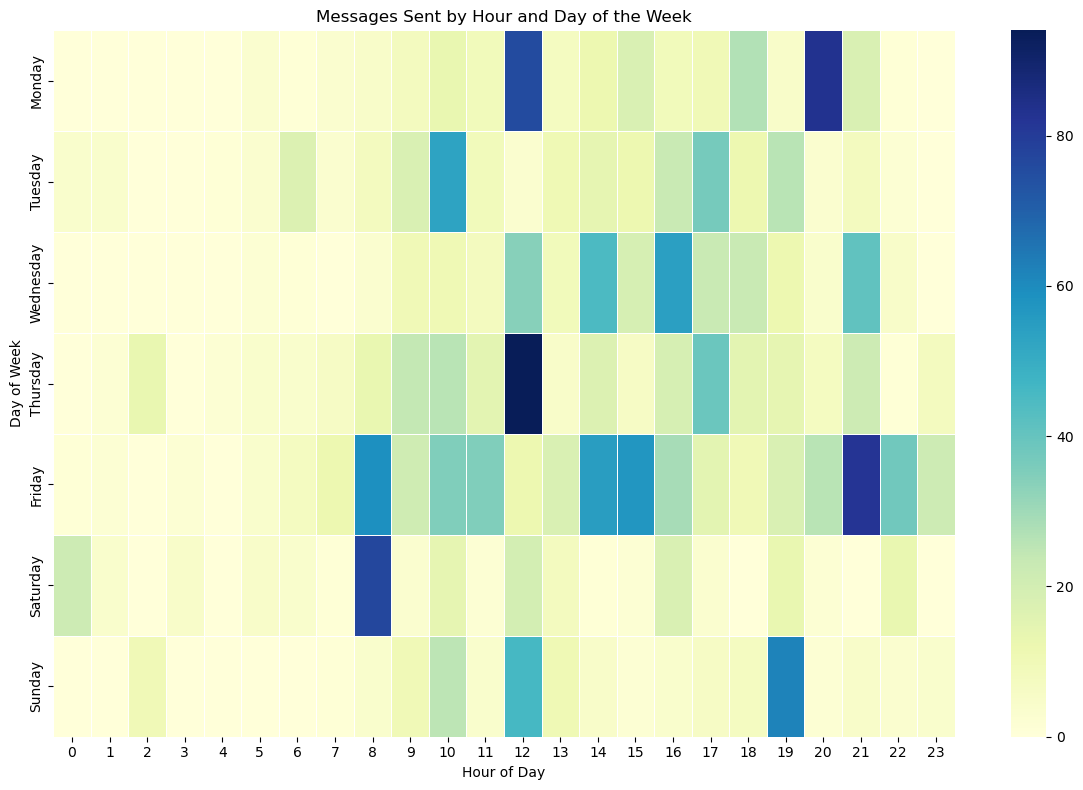

In [55]:
import seaborn as sns

# Create a pivot table for heatmap data
heatmap_data = df.pivot_table(index=df['Timestamp'].dt.day_name(), 
                              columns=df['Timestamp'].dt.hour, 
                              aggfunc='size', fill_value=0)

# Reorder the index to start from Monday to Sunday
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Messages Sent by Hour and Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

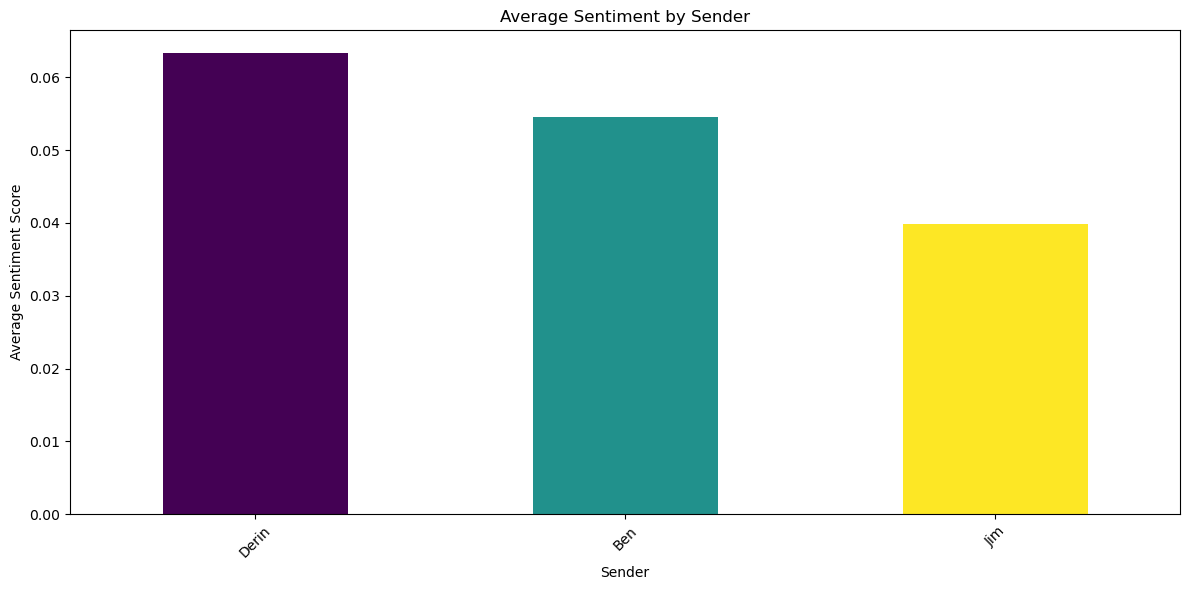

In [56]:
from textblob import TextBlob
import matplotlib.pyplot as plt

# Function to get sentiment polarity (-1: negative, 1: positive)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to each message
df['Sentiment'] = df['Content'].apply(lambda x: get_sentiment(str(x)))

# Group by sender and calculate the average sentiment score
average_sentiment_by_sender = df.groupby('Sender')['Sentiment'].mean()

# Plot the results (Top 10 senders with the highest average sentiment)
plt.figure(figsize=(12, 6))
average_sentiment_by_sender.sort_values(ascending=False).head(10).plot(kind='bar', color=colors)
plt.title('Average Sentiment by Sender')
plt.xlabel('Sender')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clean Up Data

# Send to OpenAI